# **FlightMate -  Your AI companion for all flight related queries.**

**Requirements**

In [ ]:
!pip install nx-arangodb
!nvidia-smi
!nvcc --version
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU
!pip install python-arango
!pip install --upgrade langchain langchain-community langchain-openai langgraph
!pip install arango-datasets
!pip install pyvis
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 743.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 whi

In [ ]:
# 5. Import the required modules

import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

[16:41:35 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [ ]:
from arango import ArangoClient
from arango_datasets import Datasets
import matplotlib.pyplot as plt
from pyvis.network import Network
import requests
from IPython.display import Markdown, display

Connecting to the AranagoDB database

In [ ]:
# Connecting to the ArangoDB database

db = ArangoClient(hosts="https://9a96d141c84b.arangodb.cloud:8529").db(username="root", password="sZEt1QzAmRl6NS9U3e3r", verify=True)

print(db)

<StandardDatabase _system>


**Dataset - Flights (Using one of the ArangoDB's provided datasets)**

In [ ]:
from arango import ArangoClient
from arango_datasets import Datasets

datasets = Datasets(db)

# Loading the dataset into the ArangoDB instance
datasets.load("FLIGHTS")

Output()

Initializing collection 'airports'


Output()

Output()

Initializing collection 'flights'


Output()

Output()

In [ ]:
# more information about the dataset
print(datasets.dataset_info("FLIGHTS"))

{'files': 2, 'edges': [{'collection_name': 'flights', 'files': ['https://arangodb-dataset-library.s3.amazonaws.com/flights_dataset/edges/flights.json']}], 'vertices': [{'collection_name': 'airports', 'files': ['https://arangodb-dataset-library.s3.amazonaws.com/flights_dataset/vertices/airports.json']}], 'file_type': 'json', 'label': 'FLIGHTS', 'edge_definitions': [{'edge_collection': 'flights', 'from_vertex_collections': ['airports'], 'to_vertex_collections': ['airports']}]}


In [ ]:
db

<StandardDatabase _system>

In [ ]:
# connecting to the same dataset
# creating a graph instance for integrating networkx with ArangoDB storage and quering

G_adb = nxadb.Graph(name="FLIGHTS", db=db)

print(G_adb)

[00:37:16 +0000] [INFO]: Graph 'FLIGHTS' exists.
INFO:nx_arangodb:Graph 'FLIGHTS' exists.
[00:37:17 +0000] [INFO]: Default node type set to 'airports'
INFO:nx_arangodb:Default node type set to 'airports'


Graph named 'FLIGHTS' with 3375 nodes and 286463 edges


Visulaizing a sample of sub-graph

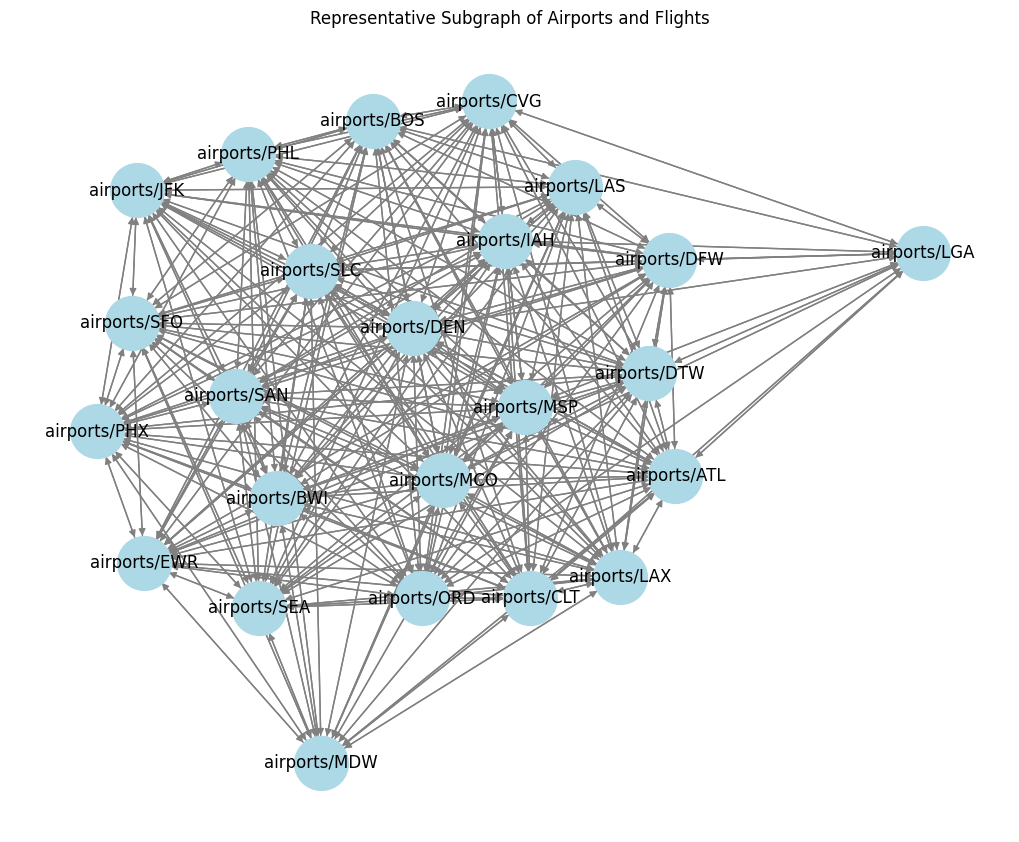

In [ ]:
from arango import ArangoClient
import networkx as nx
import matplotlib.pyplot as plt

# sample AQL query for subgraph
aql = """
LET hubs = (
  FOR a IN airports
    LET flightCount = (
      FOR f IN flights
        FILTER f._from == a._id OR f._to == a._id
        COLLECT WITH COUNT INTO cnt
        RETURN cnt
    )[0]
    FILTER flightCount >= 7000
    RETURN a._id
)
FOR f IN flights
  FILTER f._from IN hubs AND f._to IN hubs
  RETURN f
"""

#execute the query on the database instannce
results = db.aql.execute(aql)
flights = list(results)

# Build NetworkX graph
G = nx.DiGraph()
for flight in flights:
    source = flight['_from']
    target = flight['_to']
    G.add_node(source)
    G.add_node(target)
    G.add_edge(source, target)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500)
plt.title("Representative Subgraph of Airports and Flights")
plt.show()


Visualizing sample interactive graphs

In [ ]:
query = """
   WITH airports, flights

        FOR v1 IN airports FILTER v1._key == "JFK" // Start at JFK
        FOR v2 IN airports                          // Find possible layovers
          FOR v3 IN airports FILTER v3._key == "SFO" // Ensure destination is SFO

          FOR e1 IN flights
            FILTER e1._from == v1._id AND e1._to == v2._id  // JFK → Layover
          FOR e2 IN flights
            FILTER e2._from == v2._id AND e2._to == v3._id  // Layover → SFO

          LET total_distance = e1.Distance + e2.Distance
          SORT total_distance ASC
          LIMIT 1

          RETURN {
            path: [v1._key, v2._key, v3._key],
            airlines: [e1.UniqueCarrier, e2.UniqueCarrier],
            total_distance: total_distance
          }


"""

In [ ]:
flights = db.aql.execute(query)

In [ ]:
results = flights.batch()

In [ ]:
results

deque([{'path': ['JFK', 'ORD', 'SFO'],
        'airlines': ['OH', 'UA'],
        'total_distance': 2586}])

In [ ]:
from arango import ArangoClient
import networkx as nx
from pyvis.network import Network


In [ ]:
import networkx as nx

# Assuming flights is a list of flight data (list of dictionaries)
G = nx.DiGraph()

# Add edges to the graph with flight data
for flight in results:
    # Extract source and destination airports
    src = flight["path"][0]  # Extract airport ID (e.g., "JFK")
    stopover = flight["path"][1]
    dst = flight["path"][2]    # Extract destination airport ID (e.g., "SFO")

    # Get the flight distance and airline
    distance = flight["total_distance"]
    airline = flight["airlines"]

    # Add edge to the graph with weight (distance) and airline as attributes
    G.add_edge(src, stopover, airline=airline[0])
    G.add_edge(stopover, dst, airline=airline[1])


# Convert to Pyvis
net = Network(notebook=True, directed=True)
net.from_nx(G)

# Add edge labels with attributes
for edge in G.edges(data=True):
    src, dst, attrs = edge
    label = f"{attrs['airline']}"
    net.add_edge(src, dst, title=label)  # Title shows on hover

net.set_options('{"physics": {"enabled": false}}')

# Show interactive graph
net.show("sample1.html")
from IPython.display import display, HTML
display(HTML("sample1.html"))


sample1.html


In [ ]:
from arango import ArangoClient
import networkx as nx
from pyvis.network import Network

# Run AQL query
query = """
LET hubs = (
  FOR a IN airports
    LET flightCount = (
      FOR f IN flights
        FILTER f._from == a._id OR f._to == a._id
        COLLECT WITH COUNT INTO cnt
        RETURN cnt
    )[0]
    FILTER flightCount >= 12500
    RETURN a._id
)

FOR f IN flights
  FILTER f._from IN hubs AND f._to IN hubs
  RETURN {
    from: f._from,
    to: f._to,
    distance: f.Distance,
    airline: f.UniqueCarrier
  }
"""

# Execute query
flights = db.aql.execute(query)
print(flights.batch())

# Create NetworkX graph
G = nx.DiGraph()
for flight in flights:
    # print(flight)
    src = flight["from"].split("/")[1]  # Extract airport ID
    dst = flight["to"].split("/")[1]
    G.add_edge(src, dst, distance=flight["distance"], airline=flight["airline"])

# Convert to Pyvis
net = Network(notebook=True, directed=True)
net.from_nx(G)

# Add edge labels with attributes
for edge in G.edges(data=True):
    src, dst, attrs = edge
    label = f"{attrs['airline']} ({attrs['distance']} km)"
    net.add_edge(src, dst, title=label)  # Title shows on hover

net.set_options('{"physics": {"enabled": false}}')

# Show interactive graph
net.show("sample2.html")
from IPython.display import display, HTML
display(HTML("sample2.html"))

deque([{'from': 'airports/ATL', 'to': 'airports/IAH', 'distance': 689, 'airline': 'CO'}, {'from': 'airports/ATL', 'to': 'airports/DFW', 'distance': 732, 'airline': 'AA'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/DTW', 'distance': 594, 'airline': 'NW'}, {'from': 'airports/ATL', 'to': 'airports/LAX', 'distance': 1946, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'UA'}, {'from': 'airports/ATL', 'to': 'airports/DEN', 'distance': 1199, 'airline': 'F9'}, {'from': 'airports/ATL', 'to': 'airports/DFW', 'distance': 732, 'airline': 'AA'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'AA'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/PHX', 'distance': 1587, 'airline': 'US'}, {'from': 'airports/ATL', 'to': 'airports/DFW', 'distance': 732, 'airline': 'DL'}, {'from

# **BUILDING THE AGENTIC APP**

In [ ]:
arango_graph = ArangoGraph(db)

In [ ]:
import requests
from IPython.display import Markdown, display

In [ ]:
arango_graph.schema

{'Graph Schema': [{'graph_name': 'FLIGHTS',
   'edge_definitions': [{'edge_collection': 'flights',
     'from_vertex_collections': ['airports'],
     'to_vertex_collections': ['airports']}]}],
 'Collection Schema': [{'collection_name': 'airports',
   'collection_type': 'document',
   'document_properties': [{'name': '_key', 'type': 'str'},
    {'name': '_id', 'type': 'str'},
    {'name': '_rev', 'type': 'str'},
    {'name': 'name', 'type': 'str'},
    {'name': 'city', 'type': 'str'},
    {'name': 'state', 'type': 'str'},
    {'name': 'country', 'type': 'str'},
    {'name': 'lat', 'type': 'float'},
    {'name': 'long', 'type': 'float'},
    {'name': 'vip', 'type': 'bool'}],
   'example_document': {'_key': '00M',
    '_id': 'airports/00M',
    '_rev': '_jVtI30a---',
    'name': 'Thigpen ',
    'city': 'Bay Springs',
    'state': 'MS',
    'country': 'USA',
    'lat': 31.95376472,
    'long': -89.23450472,
    'vip': False}},
  {'collection_name': 'flights',
   'collection_type': 'edge',


In [ ]:
from dotenv import load_dotenv
import os

load_dotenv(".env")  # Load environment variables

api_key = os.getenv("OPENAI_API_KEY")
print(api_key[0:8])  # Verify if the key is loaded


sk-proj-


In [ ]:
import os
import requests
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
from openai import OpenAI


# Tools

For converting natural language

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ArangoGraphQAChain
@tool
def text_to_aql_to_text(query: str):
    """
    Converts a natural language query into an AQL query, executes it on an ArangoDB graph,
    and translates the result back into natural language.
    """

    # Step 1: Initialize LLM (GPT-4o for best performance)
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    # Step 2: Create the ArangoGraphQAChain
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )

    # Step 3: Define a structured system message for clarity
    system_message = """
    You are an expert in querying ArangoDB graphs using AQL.
    Your task is to:
    - Translate natural language questions into optimized AQL queries.
    - Execute the AQL queries on the given graph database.
    - Return precise and accurate results in well-formatted natural language.

    Focus on:
    - Understanding the intent behind the query.
    - Generating **efficient** and **optimized** AQL queries.
    - Providing structured, **clear** answers with context.

    **Examples of Queries and AQL Translations:**
    """

    # Step 4: Define example queries to enhance precision
    examples = """
    **User Query:** What flights are available from JFK?
    **AQL Query:**
    ```
    FOR flight IN flights
      FILTER flight._from == "airports/JFK"
      RETURN { destination: flight._to, airline: flight.airline, departure_time: flight.departure_time }
    ```
    **Answer:** Flights from JFK include [list of destinations] operated by [airline names].

    **User Query:** What is the shortest flight path from JFK to SFO?
    **AQL Query:**
    ```
    FOR v, e IN OUTBOUND SHORTEST_PATH
      "airports/JFK" TO "airports/SFO"
      GRAPH "FlightGraph"
      OPTIONS { weightAttribute: "distance" }
      RETURN { airport: v.name, airline: e.airline, distance: e.distance }
    ```
    **Answer:** The shortest flight path from JFK to SFO goes through [list of airports] with airlines [list of airlines].


    **User Query:** What is the shortest flight from JFK to SFO with one stop in between?
    **AQL Query:**
    ```
   WITH airports, flights

        FOR v1 IN airports FILTER v1._key == "JFK" // Start at JFK
        FOR v2 IN airports                          // Find possible layovers
          FOR v3 IN airports FILTER v3._key == "SFO" // Ensure destination is SFO

          FOR e1 IN flights
            FILTER e1._from == v1._id AND e1._to == v2._id  // JFK → Layover
          FOR e2 IN flights
            FILTER e2._from == v2._id AND e2._to == v3._id  // Layover → SFO

          LET total_distance = e1.Distance + e2.Distance
          SORT total_distance ASC
          LIMIT 1

          RETURN {
            path: [v1._key, v2._key, v3._key],
            airlines: [e1.UniqueCarrier, e2.UniqueCarrier],
            total_distance: total_distance
          }

        ```
    **Answer:** The shortest flight path with one stop in between from JFK to SFO goes through [list of airports] with airlines [list of airlines].
    """

    # Step 5: Append system message & examples to refine context
    final_query = query + "\n\n" + system_message + examples

    # Step 6: Execute query with error handling
    try:
        result = chain.invoke(final_query)
        return str(result["result"])
    except Exception as e:
        return f"Error processing query: {str(e)}"


In [ ]:
import re
import networkx as nx
from langchain.chat_models import ChatOpenAI

@tool
def text_to_nx_algorithm_to_text(query):
    """
    This tool executes a NetworkX algorithm on an ArangoDB Graph to answer
    a natural language query. It determines the best algorithm for tasks
    like shortest path, connectivity, centrality, and clustering.

    If the query can be efficiently solved using AQL, it avoids NetworkX.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    # Step 1: Determine the best graph algorithm for the query
    algo_selection_prompt = f"""
    I have a NetworkX Graph `G_adb` with schema: {arango_graph.schema}

    User's query: "{query}"

    Identify which **graph algorithm** should be used:
    - Use **shortest path** (`nx.shortest_path()`) if the user asks for the quickest, shortest, or optimal route.
    - Use **connectivity** (`nx.is_connected()`, `nx.connected_components()`) if the user asks about reachability.
    - Use **centrality** (`nx.betweenness_centrality()`) if the user asks for the most important nodes.
    - Use **clustering** (`nx.clustering()`) if the user asks about communities or tightly connected nodes.

    Respond with only the best-suited algorithm's function name.
    """

    selected_algorithm = llm.invoke(algo_selection_prompt).content.strip()

    # Step 2: Generate NetworkX code for the selected algorithm
    nx_code_prompt = f"""
    I have a NetworkX Graph `G_adb`. It follows this schema: {arango_graph.schema}

    User's query: "{query}"

    Based on the query, you selected `{selected_algorithm}` as the best algorithm.

    Try to understand the user's intent behind the query. And strictly stick to the schema to avoid syntax errors

    Now, generate the **precise** Python code to solve this using `G_adb`, as you are an expert at generating accurate python code for networkx.
    - Assume only `networkx` and base Python libraries are installed.
    - Ensure `FINAL_RESULT` stores the concise answer.
    - If shortest path is needed, assume the user wants the path **from a start node to an end node**.
    Your code:
    """

    text_to_nx = llm.invoke(nx_code_prompt).content
    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print("Generated NetworkX Code:\n", text_to_nx_cleaned)

    # Step 3: Execute the generated NetworkX code
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        FINAL_RESULT = local_vars.get("FINAL_RESULT", "No result found.")
    except Exception as e:
        return f"Execution Error: {e}"

    # Step 4: Convert Result Back to Natural Language
    response_prompt = f"""
    I executed the following Python code:

    ```
    {text_to_nx_cleaned}
    ```

    The computed result (`FINAL_RESULT`) is: {FINAL_RESULT}

    Now, summarize this result into a short and **clear** natural language answer.
    """

    return llm.invoke(response_prompt).content


In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ArangoGraphQAChain
#function to help the visulaize graph tool
def text_to_aql(query: str):
    """
    Converts a natural language query into an AQL query, and returns the generated query result, for graph visualization
    """

    # Step 1: Initialize LLM (GPT-4o for best performance)
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    # Step 2: Create the ArangoGraphQAChain
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        return_aql_query=True,
        return_aql_result=True,
        allow_dangerous_requests=True
    )

    # Step 3: Define a structured system message for clarity
    system_message = """
    You are an expert in querying ArangoDB graphs using AQL.
    Your task is to:
    - Translate natural language questions into optimized AQL queries.
    - Execute the AQL queries on the given graph database.
    - Return precise and accurate results

    Focus on:
    - Understanding the intent behind the query.
    - Generating **efficient** and **optimized** AQL queries.
    - Providing structured, **clear** answers with context.
    - Ensure `FINAL_RESULT` stores the concise generated query.
    - And Since this result will be used for generating graph, please make sure the query returns all the connected edges and nodes along with all its attributes
    - Also make sure the query returns the nodes and edge attributes of the source node in question, in order to visualize the graph

    Note: Can you please store the generated query in the variable `FINAL_RESULT` and return it along with the answer?

    **Examples of Queries and AQL Translations:**
    """

    # Step 4: Define example queries to enhance precision
    examples = """
    **User Query:** What flights are available from JFK?
    **AQL Query:**
    ```
    FOR flight IN flights
      FILTER flight._from == "airports/JFK"
      RETURN { destination: flight._to, airline: flight.airline, departure_time: flight.departure_time }
    ```
    **User Query:** What is the shortest flight path from JFK to SFO?
    **AQL Query:**
    ```
    FOR v, e IN OUTBOUND SHORTEST_PATH
      "airports/JFK" TO "airports/SFO"
      GRAPH "FlightGraph"
      OPTIONS { weightAttribute: "distance" }
      RETURN { airport: v.name, airline: e.airline, distance: e.distance }
    ```

    **User Query:** What is the shortest flight from JFK to SFO with one stop in between?
    **AQL Query:**
    ```
   WITH airports, flights

        FOR v1 IN airports FILTER v1._key == "JFK" // Start at JFK
        FOR v2 IN airports                          // Find possible layovers
          FOR v3 IN airports FILTER v3._key == "SFO" // Ensure destination is SFO

          FOR e1 IN flights
            FILTER e1._from == v1._id AND e1._to == v2._id  // JFK → Layover
          FOR e2 IN flights
            FILTER e2._from == v2._id AND e2._to == v3._id  // Layover → SFO

          LET total_distance = e1.Distance + e2.Distance
          SORT total_distance ASC
          LIMIT 1

          RETURN {
            path: [v1._key, v2._key, v3._key],
            airlines: [e1.UniqueCarrier, e2.UniqueCarrier],
            total_distance: total_distance
          }
        ```
    """

    # Step 5: Append system message & examples to refine context
    final_query = query + "\n\n" + system_message + examples

    # Step 6: Execute query with error handling
    try:
        result = chain.invoke(final_query)
        query = result.get("aql_query")
        response = result.get('aql_result')
        return result
    except Exception as e:
        return f"Error processing query: {str(e)}"


In [ ]:
ans = text_to_aql("Flights from JFK with UA as the airline")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH airports, flights

FOR flight IN flights
  FILTER flight._from == "airports/JFK" AND flight.UniqueCarrier == "UA"
  RETURN { destination: flight._to, airline: flight.UniqueCarrier, departure_time: flight.DepTime, arrival_time: flight.ArrTime, distance: flight.Distance }

AQL Result:
[{'destination': 'airports/SFO', 'airline': 'UA', 'departure_time': 11, 'arrival_time': 327, 'distance': 2586}, {'destination': 'airports/SFO', 'airline': 'UA', 'departure_time': 602, 'arrival_time': 917, 'distance': 2586}, {'destination': 'airports/LAX', 'airline': 'UA', 'departure_time': 651, 'arrival_time': 957, 'distance': 2475}, {'destination': 'airports/SFO', 'airline': 'UA', 'departure_time': 808, 'arrival_time': 1146, 'distance': 2586}, {'destination': 'airports/LAX', 'airline': 'UA', 'departure_time': 828, 'arrival_time': 1155, 'distance': 2475}, {'destination': 'airports/LAX', 'airline': 'UA', 'departure_time': 1133, 'arrival_time': 

In [ ]:
ans.get('aql_result')

[{'destination': 'airports/SFO',
  'airline': 'UA',
  'departure_time': 11,
  'arrival_time': 327,
  'distance': 2586},
 {'destination': 'airports/SFO',
  'airline': 'UA',
  'departure_time': 602,
  'arrival_time': 917,
  'distance': 2586},
 {'destination': 'airports/LAX',
  'airline': 'UA',
  'departure_time': 651,
  'arrival_time': 957,
  'distance': 2475},
 {'destination': 'airports/SFO',
  'airline': 'UA',
  'departure_time': 808,
  'arrival_time': 1146,
  'distance': 2586},
 {'destination': 'airports/LAX',
  'airline': 'UA',
  'departure_time': 828,
  'arrival_time': 1155,
  'distance': 2475},
 {'destination': 'airports/LAX',
  'airline': 'UA',
  'departure_time': 1133,
  'arrival_time': 1455,
  'distance': 2475},
 {'destination': 'airports/SFO',
  'airline': 'UA',
  'departure_time': 1113,
  'arrival_time': 1415,
  'distance': 2586},
 {'destination': 'airports/SFO',
  'airline': 'UA',
  'departure_time': 1139,
  'arrival_time': 1527,
  'distance': 2586},
 {'destination': 'airport

In [ ]:
import requests

In [ ]:
graph_examples = """
Example1:

aql_query: ```
   WITH airports, flights

        FOR v1 IN airports FILTER v1._key == "JFK" // Start at JFK
        FOR v2 IN airports                          // Find possible layovers
          FOR v3 IN airports FILTER v3._key == "SFO" // Ensure destination is SFO

          FOR e1 IN flights
            FILTER e1._from == v1._id AND e1._to == v2._id  // JFK → Layover
          FOR e2 IN flights
            FILTER e2._from == v2._id AND e2._to == v3._id  // Layover → SFO

          LET total_distance = e1.Distance + e2.Distance
          SORT total_distance ASC
          LIMIT 1

          RETURN {
            path: [v1._key, v2._key, v3._key],
            airlines: [e1.UniqueCarrier, e2.UniqueCarrier],
            total_distance: total_distance
          }


```

aql_result: ''' [{'path': ['JFK', 'ORD', 'SFO'],
        'airlines': ['OH', 'UA'],
        'total_distance': 2586} ]'''

Generated graph code : ``` import networkx as nx

# Assuming flights is a list of flight data (list of dictionaries)
G = nx.DiGraph()

# Add edges to the graph with flight data
for flight in results:
    # Extract source and destination airports
    src = flight["path"][0]  # Extract airport ID (e.g., "JFK")
    stopover = flight["path"][1]
    dst = flight["path"][2]    # Extract destination airport ID (e.g., "SFO")

    # Get the flight distance and airline
    distance = flight["total_distance"]
    airline = flight["airlines"]

    # Add edge to the graph with weight (distance) and airline as attributes
    G.add_edge(src, stopover, airline=airline[0])
    G.add_edge(stopover, dst, airline=airline[1])


# Convert to Pyvis
net = Network(notebook=True, directed=True)
net.from_nx(G)

# Add edge labels with attributes
for edge in G.edges(data=True):
    src, dst, attrs = edge
    label = f"{attrs['airline']}"
    net.add_edge(src, dst, title=label)  # Title shows on hover

net.set_options('{"physics": {"enabled": false}}')

# Show interactive graph
net.save_graph("airport_network.html")
filename = "airport_network.html"
from google.colab import files
files.download("/content/airport_network.html")
 ```

Example2:

aql_query: ```
LET hubs = (
  FOR a IN airports
    LET flightCount = (
      FOR f IN flights
        FILTER f._from == a._id OR f._to == a._id
        COLLECT WITH COUNT INTO cnt
        RETURN cnt
    )[0]
    FILTER flightCount >= 12500
    RETURN a._id
)

FOR f IN flights
  FILTER f._from IN hubs AND f._to IN hubs
  RETURN {
    from: f._from,
    to: f._to,
    distance: f.Distance,
    airline: f.UniqueCarrier
  }
```

aql_result: ``` [{'from': 'airports/ATL', 'to': 'airports/IAH', 'distance': 689, 'airline': 'CO'}, {'from': 'airports/ATL', 'to': 'airports/DFW', 'distance': 732, 'airline': 'AA'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/DTW', 'distance': 594, 'airline': 'NW'}, {'from': 'airports/ATL', 'to': 'airports/LAX', 'distance': 1946, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'UA'}, {'from': 'airports/ATL', 'to': 'airports/DEN', 'distance': 1199, 'airline': 'F9'}, {'from': 'airports/ATL', 'to': 'airports/DFW', 'distance': 732, 'airline': 'AA'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'AA'}, {'from': 'airports/ATL', 'to': 'airports/ORD', 'distance': 606, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/PHX', 'distance': 1587, 'airline': 'US'}, {'from': 'airports/ATL', 'to': 'airports/DFW', 'distance': 732, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/DEN', 'distance': 1199, 'airline': 'UA'}, {'from': 'airports/ATL', 'to': 'airports/LAS', 'distance': 1747, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/DTW', 'distance': 594, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/DEN', 'distance': 1199, 'airline': 'DL'}, {'from': 'airports/ATL', 'to': 'airports/LAX', 'distance': 1946, 'airline': 'DL'}]  ```

Generated graph code:

```
# Create NetworkX graph
G = nx.DiGraph()
for flight in flights:
    # print(flight)
    src = flight["from"].split("/")[1]  # Extract airport ID
    dst = flight["to"].split("/")[1]
    G.add_edge(src, dst, distance=flight["distance"], airline=flight["airline"])

# Convert to Pyvis
net = Network(notebook=True, directed=True)
net.from_nx(G)

# Add edge labels with attributes
for edge in G.edges(data=True):
    src, dst, attrs = edge
    label = f"{attrs['airline']} ({attrs['distance']} km)"
    net.add_edge(src, dst, title=label)  # Title shows on hover

net.set_options('{"physics": {"enabled": false}}')

# Show interactive graph
from google.colab import files
net.save_graph("airport_network.html")
filename = "airport_network.html"
from google.colab import files
files.download("/content/airport_network.html")
 ```
  """

In [ ]:

@tool
def visualize_graph(query: str):
    """ This tool is used when we need to visualize flight paths or graphs based on the data, first by generating AQL queries
    and then with those results, then genereate and download a graph visualization using networkx and pyvis"""

    from langchain_openai import ChatOpenAI
    import re
    from IPython.display import display, HTML, IFrame
    import json

    # Initialize the LLM
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    results = text_to_aql(query)

    query = results.get("aql_query")
    response = results.get('aql_result')

    # Generate NetworkX visualization code with the sample data
    nx_prompt = f""" You are an expert at generating code in NetworkX and pyvis to visualize the graphs based on the results from the aql query.
     The query is: {query}
     The results are: {json.dumps(response)}
     Make sure to use them efficiently to build an appropriate graph, then write and execute code to visualize it using pyvis.

     The data structure contains flights with source, destination, airline, and distance information.
     Create a directed graph where airports are nodes and flights are edges.

     Keep the output structure of the aql results obtained from the query in mind in order to extract the correct information for building the graph

     Please generate code that:
     1. Creates nodes for each unique airport
     2. Creates directed edges between airports with airline and distance as attributes
     5. Returns an HTML visualization

     Please only return the Python code without explanations or backticks.
     Ensure `filename` stores the .html file.
     Your code:
    """
    nx_prompt = nx_prompt + "\n" +graph_examples
    # Get the NetworkX and Pyvis code
    text_to_nx = llm.invoke(nx_prompt).content

    # Clean up the generated code
    text_to_nx_cleaned = re.sub(r"^```python\n|^```\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print("Generated visualization code...")
    print(text_to_nx_cleaned)
    local_vars = {}
    flag = False

    # Execute the generated NetworkX code
    try:
        # Create a local namespace to capture the output
        local_namespace = {'results': results}

        # Execute the visualization code
        exec(text_to_nx_cleaned, globals(), local_vars)
        filename = local_vars.get("filename")

        from google.colab import files
        files.download(filename)
        flag = True
        print("Visualization created successfully!")

        if flag:
          return "Graph successfully created and an interactive visualization is shown in the side pannel"
        else:
          return "Unable to obtain the visulaization"
    except Exception as e:
        error_message = f"Visualization Error: {str(e)}\n\n"

In [ ]:
api_key='MD8BQW3YYCTH8E4HXW5PL9CTU'

In [ ]:
def get_data(start_date, end_date, api_key, location):
  api_key='MD8BQW3YYCTH8E4HXW5PL9CTU'

  api_url = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?&aggregateHours=24&startDateTime={start_date}T00:00:00&endDateTime={end_date}T00:00:00&unitGroup=uk&contentType=json&dayStartTime=0:0:00&dayEndTime=0:0:00&location={location}&key={api_key}'

  response = requests.get(api_url)
  if response.status_code == 200:
    # Request was successful, and you can process the response data.
    data = response.json()
  else:
    # Handle the error, e.g., print an error message.
    print(f"Error: {response.status_code} - {response.text}")

  return data

In [ ]:
import requests
from langchain.tools import tool
from datetime import date, timedelta

api_key='MD8BQW3YYCTH8E4HXW5PL9CTU'

@tool
def get_weather(location: str) -> str:
    """
    Fetches the current weather for a given location.

    Parameters:
    - location (str): The name of the city or region.

    Returns:
    - str: A natural language summary of the weather conditions.
    """

    location = location + ',US'

    start_date = date.today() - timedelta(days=1)
    end_date = date.today()

    data = get_data(start_date,end_date, api_key, location)

    for entry in data['locations'][location]['values']:
          temp = entry.get('temp')
          humidity = entry.get('humidity')
          break


    return f"The current weather in {location} is {temp}°C "





In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType

# Create the Agentic Application

# Defining the tools
tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, get_weather, visualize_graph]

# Query function
def query_graph(query):
    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")  # Use a model that supports function calling

    # Initialize agent properly
    agent = initialize_agent(
        tools=tools,
        llm=llm,
        agent=AgentType.OPENAI_FUNCTIONS,  # Use OpenAI's function-calling agent
        verbose=True
    )

    response = agent.run(query)
    return response


Sample queries

In [ ]:
query_graph("Flights from JFK to MIA with one stop in between")



> Entering new AgentExecutor chain...

Invoking: `text_to_aql_to_text` with `{'query': 'Find flights from JFK to MIA with one stop in between.'}`




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH airports, flights 

FOR v1 IN airports FILTER v1._key == "JFK" // Start at JFK
FOR v2 IN airports                          // Find possible layovers
  FOR v3 IN airports FILTER v3._key == "MIA" // Ensure destination is MIA

  FOR e1 IN flights 
    FILTER e1._from == v1._id AND e1._to == v2._id  // JFK → Layover
  FOR e2 IN flights 
    FILTER e2._from == v2._id AND e2._to == v3._id  // Layover → MIA

  RETURN {
    path: [v1._key, v2._key, v3._key], 
    airlines: [e1.UniqueCarrier, e2.UniqueCarrier]
  }

AQL Result:
[{'path': ['JFK', 'ATL', 'MIA'], 'airlines': ['DL', 'AA']}, {'path': ['JFK', 'ATL', 'MIA'], 'airlines': ['DL', 'FL']}, {'path': ['JFK', 'ATL', 'MIA'], 'airlines': ['DL', 'AA']}, {'path': ['JFK', 'ATL', 'MIA'], 'airlines': ['DL', 'DL']}, {'path': ['JFK', 'ATL', 

'You can find several flight options from JFK to MIA with one stop in between. All routes include a layover at ATL (Hartsfield-Jackson Atlanta International Airport). The airlines operating these flights include Delta Air Lines (DL) and American Airlines (AA), among others. Each option provides a reliable connection, ensuring a smooth travel experience.'

In [ ]:
query_graph("Show me flights from SFO")



> Entering new AgentExecutor chain...

Invoking: `text_to_aql_to_text` with `{'query': 'Show me flights from San Francisco International Airport (SFO)'}`




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH airports, flights

FOR flight IN flights
  FILTER flight._from == "airports/SFO"
  RETURN { destination: flight._to, airline: flight.UniqueCarrier, departure_time: flight.DepTimeUTC }

AQL Result:
[{'destination': 'airports/SAN', 'airline': 'UA', 'departure_time': '2008-01-01T08:11:00.000Z'}, {'destination': 'airports/ORD', 'airline': 'AA', 'departure_time': '2008-01-01T08:14:00.000Z'}, {'destination': 'airports/CVG', 'airline': 'DL', 'departure_time': '2008-01-01T08:18:00.000Z'}, {'destination': 'airports/IAH', 'airline': 'CO', 'departure_time': '2008-01-01T08:33:00.000Z'}, {'destination': 'airports/DFW', 'airline': 'AA', 'departure_time': '2008-01-01T09:02:00.000Z'}, {'destination': 'airports/MSP', 'airline': 'NW', 'departure_time': '2008-01-01T09:24:00.000Z'}, {'d

"Here are the flights departing from San Francisco International Airport (SFO):\n\n1. **Destination:** San Diego International Airport (SAN)  \n   **Airline:** United Airlines (UA)  \n   **Departure Time:** January 1, 2008, at 08:11 AM UTC\n\n2. **Destination:** O'Hare International Airport (ORD)  \n   **Airline:** American Airlines (AA)  \n   **Departure Time:** January 1, 2008, at 08:14 AM UTC\n\n3. **Destination:** Cincinnati/Northern Kentucky International Airport (CVG)  \n   **Airline:** Delta Airlines (DL)  \n   **Departure Time:** January 1, 2008, at 08:18 AM UTC\n\n4. **Destination:** George Bush Intercontinental Airport (IAH)  \n   **Airline:** Continental Airlines (CO)  \n   **Departure Time:** January 1, 2008, at 08:33 AM UTC\n\n5. **Destination:** Dallas/Fort Worth International Airport (DFW)  \n   **Airline:** American Airlines (AA)  \n   **Departure Time:** January 1, 2008, at 09:02 AM UTC\n\n6. **Destination:** Minneapolis-Saint Paul International Airport (MSP)  \n   **A

In [ ]:
query_graph("Visualize a graph with flights flying from ATL with AA airline")

<ipython-input-27-7a6e59811c46>:10: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")  # Use a model that supports function calling
<ipython-input-27-7a6e59811c46>:13: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://pyth



> Entering new AgentExecutor chain...

Invoking: `visualize_graph` with `{'query': "FOR flight IN flights FILTER flight.source == 'ATL' AND flight.airline == 'AA' RETURN flight"}`




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH flights, airports

FOR flight IN flights
  FILTER flight._from == "airports/ATL" AND flight.UniqueCarrier == "AA"
  RETURN flight

AQL Result:
[{'_key': '306520992', '_id': 'flights/306520992', '_from': 'airports/ATL', '_to': 'airports/LGA', '_rev': '_jUsIFAu--k', 'Year': 2008, 'Month': 1, 'Day': 1, 'DayOfWeek': 2, 'DepTime': 620, 'ArrTime': 820, 'DepTimeUTC': '2008-01-01T11:20:00.000Z', 'ArrTimeUTC': '2008-01-01T13:20:00.000Z', 'UniqueCarrier': 'AA', 'FlightNum': 1142, 'TailNum': 'N512AA', 'Distance': 761}, {'_key': '306521038', '_id': 'flights/306521038', '_from': 'airports/ATL', '_to': 'airports/MIA', '_rev': '_jUsIFAy--e', 'Year': 2008, 'Month': 1, 'Day': 1, 'DayOfWeek': 2, 'DepTime': 628, 'ArrTime': 815, 'DepTimeUTC': '2008-01-01T11:28:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualization created successfully!
NoneIt seems that there was an issue visualizing the graph for flights from ATL with the AA airline. Unfortunately, I cannot generate the visualization at this moment. 

If you have any other requests or need information about flights, feel free to ask!

> Finished chain.


'It seems that there was an issue visualizing the graph for flights from ATL with the AA airline. Unfortunately, I cannot generate the visualization at this moment. \n\nIf you have any other requests or need information about flights, feel free to ask!'

In [ ]:
query_graph("What is the Weather in Virginia")

<ipython-input-67-7a6e59811c46>:13: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(
<ipython-input-67-7a6e59811c46>:20: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent.run(query)




> Entering new AgentExecutor chain...

Invoking: `get_weather` with `{'location': 'Virginia'}`


The current weather in Virginia,US is 5.4°C The current weather in Virginia, US is 5.4°C.

> Finished chain.


'The current weather in Virginia, US is 5.4°C.'

In [ ]:
query_graph("Is there an airport in Tampa")



> Entering new AgentExecutor chain...

Invoking: `text_to_aql_to_text` with `{'query': 'Is there an airport in Tampa?'}`




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
FOR airport IN airports
  FILTER airport.city == "Tampa"
  RETURN airport

AQL Result:
[{'_key': 'TPA', '_id': 'airports/TPA', '_rev': '_jUsH4rq--V', 'name': 'Tampa International ', 'city': 'Tampa', 'state': 'FL', 'country': 'USA', 'lat': 27.97547222, 'long': -82.53325, 'vip': False}, {'_key': 'TPF', '_id': 'airports/TPF', '_rev': '_jUsH4rq--W', 'name': 'Peter O. Knight', 'city': 'Tampa', 'state': 'FL', 'country': 'USA', 'lat': 27.91557833, 'long': -82.44926083, 'vip': False}, {'_key': 'X16', '_id': 'airports/X16', '_rev': '_jUsH4ru--8', 'name': 'Vandenberg ', 'city': 'Tampa', 'state': 'FL', 'country': 'USA', 'lat': 28.01398389, 'long': -82.34527917, 'vip': False}]

> Finished chain.
Yes, there are several airports in Tampa. The main ones include Tampa International Airport (TPA), Peter O. Knight Airport

'Yes, there are several airports in Tampa. The main ones include Tampa International Airport (TPA), Peter O. Knight Airport (TPF), and Vandenberg Airport (X16). Each of these airports serves the Tampa area in Florida, USA.'

In [ ]:
import openai

In [ ]:
from pydub import AudioSegment
from pydub.playback import play
import base64
from io import BytesIO
from PIL import Image

import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

    return output_filename

In [ ]:
talker("Well, hi there")

'output_audio.mp3'

In [ ]:
import gradio as gr

# **User Interface with gradio**

In [49]:
import os
import gradio as gr
from langchain.agents import AgentType, initialize_agent
from langchain.chat_models import ChatOpenAI
import html

# Function to add the user message to the chat immediately
def add_user_message(message, history):
    return history + [(message, None)]

# Function to properly embed the HTML file with all necessary scripts
def get_embedded_html(file_path):
    if not os.path.exists(file_path):
        return "<p>Network visualization file not found</p>"

    try:
        with open(file_path, "r", encoding="utf-8") as file:
            html_content = file.read()

        # Ensure the HTML has all it needs to run standalone
        # This is crucial for vis.js network visualizations
        return html_content
    except Exception as e:
        return f"<p>Error loading visualization: {str(e)}</p>"

# Function to get the LLM's response
def get_llm_response(message, history):
    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

    # Initialize the agent
    agent = initialize_agent(
        tools=tools,
        llm=llm,
        agent=AgentType.OPENAI_FUNCTIONS,
        verbose=True
    )

    context = "\n".join([f"User: {msg[0]}\nAssistant: {msg[1]}" for msg in history if msg[1] is not None])

    # Make the agent process the context and the latest message
    response = agent.run(f"{context}\nUser: {message}\nAssistant:")
    # Get the agent's response
    # response = agent.run(history)

    # Update the last history entry with the response
    history[-1] = (history[-1][0], response)

    # Generate audio response
    audio = talker(response)

    # Load the HTML content - using absolute path
    file_path = os.path.abspath("airport_network.html")

    if os.path.exists(file_path):
          # Create an iframe to properly isolate and render the visualization
          iframe_html = f"""
          <div style="width:100%; height:600px; border:1px solid #ddd; overflow:hidden;">
              <iframe
                  srcdoc="{html.escape(get_embedded_html(file_path))}"
                  style="width:100%; height:100%; border:none;">
              </iframe>
          </div>
          """

          return history, audio, iframe_html

    else:
      return history, audio, ""

# Create Gradio UI
with gr.Blocks() as ui:
    with gr.Row():
        with gr.Column(scale=2):
            chatbot = gr.Chatbot(height=500)
            entry = gr.Textbox(
                label="Chat with our AI Assistant FlightMate:",
                placeholder="Ask anything..."
            )
            with gr.Row():
                clear = gr.Button("Clear")

        with gr.Column(scale=3):
            html_output = gr.HTML(label="Network Visualization")

    audio_output = gr.Audio(label="Response Audio", type="filepath")

    # Handle message submission
    entry.submit(
        add_user_message,
        inputs=[entry, chatbot],
        outputs=chatbot
    ).then(
        get_llm_response,
        inputs=[entry, chatbot],
        outputs=[chatbot, audio_output, html_output]
    ).then(
        lambda: "",
        None,
        entry
    )

    # Clear button functionality
    clear.click(lambda: [], None, chatbot)
    clear.click(lambda: None, None, audio_output)
    clear.click(lambda: "", None, html_output)

# Launch the Gradio UI
ui.launch(inbrowser=True, debug=True)

<ipython-input-49-cb59bd6f65c5>:74: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=500)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://60164616f1bb20f09e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




> Entering new AgentExecutor chain...
Hello! How can I assist you today?

> Finished chain.




> Entering new AgentExecutor chain...

Invoking: `get_weather` with `{'location': 'Florida'}`


The current weather in Florida,US is 16.2°C The current weather in Florida is 16.2°C. If you need more specific information or details about a particular city in Florida, just let me know!

> Finished chain.




> Entering new AgentExecutor chain...

Invoking: `visualize_graph` with `{'query': "FOR flight IN flights FILTER flight.source IN ['JFK', 'ATL', 'MIA'] RETURN flight"}`




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH airports, flights

FOR flight IN flights
  FILTER flight._from IN ['airports/JFK', 'airports/ATL', 'airports/MIA']
  RETURN flight

AQL Result:
[{'_key': '306520629', '_id': 'flights/306520629', '_from': 'airports/ATL', '_to': 'airports/CHS', '_rev': '_jVtJC4K---', 'Year': 2008, 'Month': 1, 'Day': 1, 'DayOfWeek': 2, 'DepTime': 2, 'ArrTime': 57, 'DepTimeUTC': '2008-01-01T05:02:00.000Z', 'ArrTimeUTC': '2008-01-01T05:57:00.000Z', 'UniqueCarrier': 'FL', 'FlightNum': 579, 'TailNum': 'N937AT', 'Distance': 259}, {'_key': '306520917', '_id': 'flights/306520917', '_from': 'airports/ATL', '_to': 'airports/MSP', '_rev': '_jVtJC4W--3', 'Year': 2008, 'Month': 1, 'Day': 1, 'DayOfWeek': 2, 'DepTime': 606, 'ArrTime': 741, 'DepTimeUTC': '2008-01-01T11:06:00.000Z', 'Arr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualization created successfully!
Graph successfully created and an interactive visualization is shown in the side pannelI have created a graph visualizing the flights between JFK, ATL, and MIA. You can interact with the visualization in the side panel. If you have any other requests or need further assistance, feel free to ask!

> Finished chain.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://60164616f1bb20f09e.gradio.live
